In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

from catboost import CatBoostClassifier, CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_transaction = pd.read_parquet("/kaggle/input/alfa-challenge/df_transaction.pa")
df_train = pd.read_parquet("/kaggle/input/alfa-challenge/train.pa")

test_clients = df_transaction[~df_transaction['client_num'].isin(df_train['client_num'])]['client_num'].unique()

# Генерируем фичи

In [3]:
def extract_time_features(df: pd.DataFrame, datetime_col: str = 'date_time') -> pd.DataFrame:
    """
    Извлекает временные признаки из столбца с датой и временем.
    """
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df['year_month'] = df[datetime_col].dt.to_period('M')
    df['year_week'] = df_transaction['date_time'].dt.isocalendar().week
    df['year_day'] = df[datetime_col].dt.date
    df['hour'] = df[datetime_col].dt.hour
    df['day_of_week'] = df[datetime_col].dt.dayofweek
    return df

df_transaction = extract_time_features(df_transaction, datetime_col='date_time')

## **Распределение транзакций по времени суток**

In [4]:
def calculate_hourly_distribution(df_transaction: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет распределение транзакций по часам (hourly_distribution).
    """
    hourly_distribution = (
        df_transaction.groupby(['client_num', 'hour'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )
    total_client_tx = hourly_distribution.drop(columns='client_num').sum(axis=1)
    for h in range(24):
        hourly_distribution[f'hour_{h}_ratio'] = hourly_distribution[h] / (total_client_tx + 1e-9)
    hourly_distribution = hourly_distribution.drop(columns=range(24))
    return hourly_distribution


hourly_distribution = calculate_hourly_distribution(df_transaction)

In [5]:
def calculate_weekday_distribution(df_transaction: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет распределение транзакций по дням недели (weekday_distribution).
    """
    weekday_distribution = (
        df_transaction.groupby(['client_num', 'day_of_week'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )
    total_wday_tx = weekday_distribution.drop(columns='client_num').sum(axis=1)
    for d in range(7):
        weekday_distribution[f'weekday_{d}_ratio'] = weekday_distribution[d] / (total_wday_tx + 1e-9)
    weekday_distribution = weekday_distribution.drop(columns=range(7))
    return weekday_distribution


weekday_distribution = calculate_weekday_distribution(df_transaction)

In [6]:
def calculate_time_of_day_activity(df_transaction: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет распределение транзакций по времени суток (time_of_day_activity).
    """
    df_transaction['time_of_day'] = pd.cut(
        df_transaction['hour'],
        bins=[0, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
        labels=['night', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20', '20-22', '22-24'],
        right=False
    )
    time_of_day_activity = (
        df_transaction.groupby(['client_num', 'time_of_day'], observed=False)
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )
    time_of_day_activity.columns = ['client_num'] + [f'{col}_tx' for col in time_of_day_activity.columns[1:]]
    total_tx = time_of_day_activity.filter(like='_tx').sum(axis=1)
    for col in [c for c in time_of_day_activity.columns if c.endswith('_tx')]:
        ratio_col = col.replace('_tx', '_ratio')
        time_of_day_activity[ratio_col] = time_of_day_activity[col] / (total_tx + 1e-9)
    return time_of_day_activity

time_of_day_activity = calculate_time_of_day_activity(df_transaction)

In [7]:
def calculate_weekend_activity(df_transaction: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет долю транзакций, совершённых в выходные (weekend_activity).
    """
    df_transaction['is_weekend'] = df_transaction['day_of_week'].isin([5, 6])
    weekend_activity = (
        df_transaction.groupby('client_num')['is_weekend']
        .sum()
        .reset_index(name='weekend_tx_count')
    )
    total_transactions = (
        df_transaction.groupby('client_num')['amount']
        .count()
        .reset_index(name='total_transactions')
    )
    weekend_activity = weekend_activity.merge(total_transactions, on='client_num', how='left')
    weekend_activity['weekend_tx_ratio'] = weekend_activity['weekend_tx_count'] / weekend_activity['total_transactions']
    return weekend_activity

weekend_activity = calculate_weekend_activity(df_transaction)

## **Активность клиента во времени**

In [8]:
def calculate_avg_inactive_days(df_transaction: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет средний период бездействия клиента (avg_inactive_days).
    """
    df_transaction = df_transaction.sort_values(['client_num', 'date_time'])
    df_transaction['next_date'] = df_transaction.groupby('client_num')['date_time'].shift(-1)
    df_transaction['inactive_period'] = (df_transaction['next_date'] - df_transaction['date_time']).dt.days.fillna(0)
    avg_inactive_days = (
        df_transaction.groupby('client_num')['inactive_period']
        .mean()
        .reset_index(name='avg_inactive_days')
    )
    return avg_inactive_days

avg_inactive_days = calculate_avg_inactive_days(df_transaction)

In [9]:
def calculate_average_monthly_transactions(df_transaction: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет среднее количество транзакций в месяц для каждого клиента.
    """
    min_date = df_transaction['date_time'].min()
    max_date = df_transaction['date_time'].max()
    total_months = ((max_date.year - min_date.year) * 12) + (max_date.month - min_date.month) + 1

    average_monthly_transactions = (
        df_transaction.groupby('client_num')
        .size()
        .reset_index(name='total_tx')
    )
    average_monthly_transactions['tx_per_month'] = average_monthly_transactions['total_tx'] / total_months
    return average_monthly_transactions

average_monthly_transactions = calculate_average_monthly_transactions(df_transaction)

In [10]:
def calculate_monthly_transaction_variance(df_transaction: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет коэффициент вариации транзакций по месяцам для каждого клиента.
    """
    monthly_counts = (
        df_transaction.groupby(['client_num', 'year_month'])
        .size()
        .reset_index(name='month_tx_count')
    )
    month_count_var = (
        monthly_counts.groupby('client_num')['month_tx_count']
        .agg(['mean', 'std'])
        .reset_index()
    )
    month_count_var['tx_count_coeff_var'] = month_count_var['std'] / (month_count_var['mean'] + 1e-9)
    return month_count_var[['client_num', 'tx_count_coeff_var']]

monthly_variance = calculate_monthly_transaction_variance(df_transaction)

## **Анализ суммы транзакций**

In [11]:
def calculate_client_stats(df_transaction: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет среднее, стандартное отклонение и количество транзакций для каждого клиента.
    """
    client_stats = (
        df_transaction.groupby('client_num')['amount']
        .agg(['mean', 'std', 'count'])
        .reset_index()
    )
    client_stats['coeff_var'] = client_stats['std'] / (client_stats['mean'] + 1e-9)
    client_stats.rename(
        columns={
            'mean': 'amount_mean',
            'std': 'amount_std',
            'count': 'amount_count'
        },
        inplace=True
    )
    return client_stats


client_stats = calculate_client_stats(df_transaction)

In [12]:
def create_daily_stats(df_transaction: pd.DataFrame) -> pd.DataFrame:
    daily_agg = (
        df_transaction
        .groupby(['client_num', 'year_day'])
        .agg(
            daily_sum=('amount', 'sum'),
            daily_mean=('amount', 'mean'),
            daily_median=('amount', 'median'),
            daily_std=('amount', 'std'),
            daily_count=('amount', 'count')
        )
        .reset_index()
    )
    daily_stats = (
        daily_agg.groupby('client_num')
        .agg(
            avg_daily_sum=('daily_sum', 'mean'),
            avg_daily_mean=('daily_mean', 'mean'),
            avg_daily_median=('daily_median', 'mean'),
            avg_daily_std=('daily_std', 'mean'),
            avg_daily_count=('daily_count', 'mean')
        )
        .reset_index()
    )
    return daily_stats


daily_stats = create_daily_stats(df_transaction)

In [13]:
def create_weekly_agg(df_transaction: pd.DataFrame) -> pd.DataFrame:
    weekly_agg = (
        df_transaction
        .groupby(['client_num', 'year_week'])
        .agg(
            weekly_sum=('amount', 'sum'),
            weekly_mean=('amount', 'mean'),
            weekly_median=('amount', 'median'),
            weekly_std=('amount', 'std'),
            weekly_count=('amount', 'count')
        )
        .reset_index()
    )
    weekly_agg_wide = weekly_agg.pivot(
        index='client_num',
        columns='year_week',
        values=['weekly_sum', 'weekly_mean', 'weekly_median', 'weekly_std', 'weekly_count']
    )
    weekly_agg_wide.columns = [f"{stat}_week{w}" for stat, w in weekly_agg_wide.columns]
    return weekly_agg_wide

weekly_agg_wide = create_weekly_agg(df_transaction)

In [14]:
def create_monthly_agg(df_transaction: pd.DataFrame) -> pd.DataFrame:
    monthly_agg = (
        df_transaction
        .groupby(['client_num', 'year_month'])
        .agg(
            monthly_sum=('amount', 'sum'),
            monthly_mean=('amount', 'mean'),
            monthly_median=('amount', 'median'),
            monthly_std=('amount', 'std'),
            monthly_count=('amount', 'count')
        )
        .reset_index()
    )
    monthly_agg_wide = monthly_agg.pivot(
        index='client_num',
        columns='year_month',
        values=['monthly_sum', 'monthly_mean', 'monthly_median', 'monthly_std', 'monthly_count']
    )
    monthly_agg_wide.columns = [f"{stat}_{str(period)}" for stat, period in monthly_agg_wide.columns]
    return monthly_agg_wide

monthly_agg_wide = create_monthly_agg(df_transaction)

## **Анализ MCC-кодов**

In [15]:
def map_mcc_to_category(mcc: int, mcc_categories: dict) -> str:
    for category, codes in mcc_categories.items():
        if mcc in codes:
            return category
    return 'other'


def create_mcc_features(df_transaction: pd.DataFrame, mcc_categories: dict) -> pd.DataFrame:
    """
    1) Преобразует mcc_code в числовой тип.
    2) Делает map по mcc_code -> category.
    """
    df_transaction['mcc_code'] = pd.to_numeric(df_transaction['mcc_code'], errors='coerce')
    df_transaction['category'] = df_transaction['mcc_code'].apply(lambda x: map_mcc_to_category(x, mcc_categories))
    return df_transaction

# Признаки по MCC
mcc_categories = {
    'supermarkets': [5411, 5499],
    'entertainment': [5812, 5814, 7832, 7922],
    'utilities': [4900, 4814, 4899],
    'transportation': [3000, 3299, 3351, 3441, 4011, 4121, 4131, 4111, 4722],
    'healthcare': [5912] + list(range(8011, 8100)),
    'restaurants': [5812, 5814],
    'education': [8211, 8220, 8299],
    'entertainment_and_leisure': [7832, 7922, 7997, 7996],
    'clothing_and_accessories': [5611, 5661, 5944],
    'home_and_garden': [5712, 5722, 5211],
    'telecommunications': [4814, 4816],
    'financial_services': [6012, 6211],
    'insurance': [6300],
    'household_services': [7216, 7230],
    'electronics': [5732, 5734],
    'sports_and_recreation': [5941, 7991],
    'automotive': [5541, 7538],
    'books_and_stationery': [5942, 5943],
    'charity_and_government': [8398, 9399],
    'other': []
}

df_transaction = create_mcc_features(df_transaction, mcc_categories)

In [16]:
def calculate_unique_mcc(df_transaction: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет количество уникальных MCC-кодов для каждого клиента.
    """
    unique_mcc = (
        df_transaction.groupby('client_num')
        .agg(unique_mcc=('mcc_code', 'nunique'))
        .reset_index()
    )
    return unique_mcc


unique_mcc = calculate_unique_mcc(df_transaction)

In [17]:
def calculate_category_aggregates(df_transaction: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет агрегированные статистики расходов по категориям для каждого клиента.
    """
    category_agg = (
        df_transaction.groupby(['client_num', 'category'])['amount']
        .agg(['sum', 'count', 'mean', 'median', 'min', 'max', 'std'])
        .unstack(fill_value=0)
        .reset_index()
    )

    category_agg.columns = ['client_num'] + [f'{stat}_{cat}' for stat, cat in category_agg.columns[1:]]
    return category_agg

category_aggregates = calculate_category_aggregates(df_transaction)

In [18]:
def calculate_spending_ratios(df_transaction: pd.DataFrame, mcc_categories: dict) -> pd.DataFrame:
    """
    Вычисляет доли расходов каждой категории от общего.
    """
    category_spending = (
        df_transaction.groupby(['client_num', 'category'])['amount']
        .sum()
        .unstack(fill_value=0)
        .reset_index()
    )

    for cat in mcc_categories.keys():
        if cat not in category_spending.columns:
            category_spending[cat] = 0

    category_spending['total_spending'] = category_spending[list(mcc_categories.keys())].sum(axis=1)

    for col in mcc_categories.keys():
        category_spending[f'{col}_ratio'] = np.where(
            category_spending['total_spending'] == 0, 0,
            category_spending[col] / category_spending['total_spending']
        )

    spending_ratios = category_spending[['client_num'] + [f'{col}_ratio' for col in mcc_categories.keys()]]
    return spending_ratios


spending_ratios = calculate_spending_ratios(df_transaction, mcc_categories)

In [19]:
def create_rare_mcc_feature(df_transaction: pd.DataFrame, threshold_ratio: float = 0.001) -> pd.DataFrame:
    """
    Создаёт DataFrame: ['client_num', 'rare_mcc_ratio'] — доля "редких" MCC у каждого клиента.
    """
    total_transactions = len(df_transaction)
    threshold = total_transactions * threshold_ratio
    mcc_freq = df_transaction['mcc_code'].value_counts()
    rare_mcc_codes = mcc_freq[mcc_freq < threshold].index

    rare_mcc_per_client = (
        df_transaction['mcc_code'].isin(rare_mcc_codes)
        .groupby(df_transaction['client_num'])
        .mean()
        .reset_index(name='rare_mcc_ratio')
    )
    return rare_mcc_per_client


rare_mcc_per_client = create_rare_mcc_feature(df_transaction, threshold_ratio=0.001)

In [20]:
def calculate_top_mcc_features(df_transaction: pd.DataFrame, N_values=[1, 5, 10]) -> pd.DataFrame:
    mcc_sum = (
        df_transaction.groupby(['client_num', 'mcc_code'])['amount']
        .sum()
        .reset_index()
    )
    mcc_sum['rank'] = mcc_sum.groupby('client_num')['amount'].rank(method='first', ascending=False)

    total_amount = (
        df_transaction.groupby('client_num')['amount']
        .sum()
        .reset_index(name='total_amount')
    )

    top_mcc_features = total_amount[['client_num']].copy()

    for N in N_values:
        top_mcc = mcc_sum[mcc_sum['rank'] <= N].copy()
        top_mcc_sum = (
            top_mcc.groupby('client_num')['amount']
            .sum()
            .reset_index(name=f'top{N}_mcc_sum')
        )
        top_mcc_sum = top_mcc_sum.merge(total_amount, on='client_num', how='left')
        top_mcc_sum[f'top{N}_mcc_ratio'] = top_mcc_sum[f'top{N}_mcc_sum'] / (top_mcc_sum['total_amount'] + 1e-9)

        top_mcc_features = top_mcc_features.merge(
            top_mcc_sum[['client_num', f'top{N}_mcc_ratio']],
            on='client_num',
            how='left'
        )

    return top_mcc_features


# Топ-N MCC
top_mcc_features = calculate_top_mcc_features(df_transaction, N_values=[1, 5, 10])

## **Признаки по мерчантам**

In [21]:
def calculate_unique_merchants(df_transaction: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет количество уникальных мерчантов для каждого клиента.
    """
    unique_merchants = (
        df_transaction.groupby('client_num')
        .agg(unique_merchants=('merchant_name', 'nunique'))
        .reset_index()
    )
    return unique_merchants

unique_merchants = calculate_unique_merchants(df_transaction)

## **Собираем все фичи**

In [22]:
# Распределение транзакций по времени суток
features = hourly_distribution.copy()
features = features.merge(weekday_distribution, on='client_num', how='left')
features = features.merge(weekend_activity, on='client_num', how='left')
features = features.merge(time_of_day_activity, on='client_num', how='left')

# Активность клиента во времени
features = features.merge(avg_inactive_days, on='client_num', how='left')
features = features.merge(average_monthly_transactions, on='client_num', how='left')
features = features.merge(monthly_variance, on='client_num', how='left')


# Анализ суммы транзакций
features = features.merge(client_stats, on='client_num', how='left')
features = features.merge(daily_stats, on='client_num', how='left')
features = features.merge(weekly_agg_wide, on='client_num', how='left')
features = features.merge(monthly_agg_wide, on='client_num', how='left')

# Анализ MCC-кодов
features = features.merge(unique_mcc, on='client_num', how='left')
features = features.merge(category_aggregates, on='client_num', how='left')
features = features.merge(spending_ratios, on='client_num', how='left')
features = features.merge(rare_mcc_per_client, on='client_num', how='left')
features = features.merge(top_mcc_features, on='client_num', how='left')

# Признаки по мерчантам
features = features.merge(unique_merchants, on='client_num', how='left')

In [23]:
initial_features = features.shape[1]

# Сопоставление признаков с их категориями

Это нужно для упрощения анализа важности признаков, чтобы определить вклад каждой категории признаков в итоговую модель.

In [24]:
# Определяем мапинг: group_name -> dataframe
group_to_dataframe = {
    "hourly_distribution": hourly_distribution,
    "weekday_distribution": weekday_distribution,
    "weekend_activity": weekend_activity,
    "time_of_day_activity": time_of_day_activity,
    "avg_inactive_days": avg_inactive_days,
    "average_monthly_transactions": average_monthly_transactions,
    "monthly_variance": monthly_variance,
    "client_stats": client_stats,
    "daily_stats": daily_stats,
    "weekly_agg_wide": weekly_agg_wide,
    "monthly_agg_wide": monthly_agg_wide,
    "unique_mcc": unique_mcc,
    "category_aggregates": category_aggregates,
    "spending_ratios": spending_ratios,
    "rare_mcc_per_client": rare_mcc_per_client,
    "top_mcc_features": top_mcc_features,
    "unique_merchants": unique_merchants,
}

group_dict = {}
for group_name, df in group_to_dataframe.items():
    cols = set(df.columns) - {"client_num"}
    for col in cols:
        group_dict[col] = group_name


# Подготовка данных для модели

In [25]:
nan_ratios = features.isna().mean()
nan_ratios = nan_ratios.reset_index()
nan_ratios.columns = ['Column', 'NaN_Ratio']

# Удаляем столбцы с более чем 90% NaN
nan_threshold = 0.9
high_nan_cols = nan_ratios[nan_ratios['NaN_Ratio'] > nan_threshold]['Column']
num_removed_cols = len(high_nan_cols)
features = features.drop(columns=high_nan_cols)

print(f"Удалено столбцов с более чем {nan_threshold * 100}% NaN: {num_removed_cols}")

# Замена NaN для числовых признаков
num_cols = features.select_dtypes(include=['float64', 'int64']).columns
features[num_cols] = features[num_cols].fillna(0)

Удалено столбцов с более чем 90.0% NaN: 5


In [26]:
# Установите порог для определения сильной корреляции
correlation_threshold = 0.9

df_features = features.copy()  # замените на ваши данные

# Считаем корреляцию
corr_matrix = df_features.corr().abs()

to_drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        if corr_value > correlation_threshold:
            # Удаляем одну из сильно скоррелированных фичей:
            if corr_matrix[col1].sum() > corr_matrix[col2].sum():
                to_drop.add(col1)
            else:
                to_drop.add(col2)

df_features_reduced = df_features.drop(columns=to_drop)

print(f"\nУдалено {len(to_drop)} признаков из-за сильной корреляции.")


Удалено 66 признаков из-за сильной корреляции.


In [27]:
# Сравнение количества признаков до и после обработки
reduced_features = df_features_reduced.shape[1]

print(f"Количество признаков до обработки: {initial_features}")
print(f"Количество признаков после обработки: {reduced_features}")
print(f"Удалено признаков: {initial_features - reduced_features}")

Количество признаков до обработки: 317
Количество признаков после обработки: 246
Удалено признаков: 71


In [28]:
# Разделение на train и test
train_features = df_features_reduced[df_features_reduced['client_num'].isin(df_train['client_num'])].merge(df_train[['client_num', 'target']], on='client_num', how='left')
test_features = df_features_reduced[df_features_reduced['client_num'].isin(test_clients)]

X = train_features.drop(columns=['client_num', 'target'])
y = train_features['target']

X_test = test_features.drop(columns=['client_num'])

# Разделяем данные на Train, Validation и Test
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_clf, X_reg, y_clf, y_reg = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Train clf size: {len(X_clf)}")
print(f"Train reg size: {len(X_reg)}")
print(f"Val size: {len(X_val)}")

Train clf size: 47600
Train reg size: 11900
Val size: 10500


# Определяем веса

In [29]:
# Рассчитываем веса классов
unique_classes = np.unique(y_clf)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_clf)
class_weights_dict_clf = {i: weight for i, weight in enumerate(class_weights)}

class_weights_dict_clf

{0: 0.662638861820308,
 1: 0.554920842173984,
 2: 1.0129599284969462,
 3: 1.2520714417234395,
 4: 1.2447373238147539,
 5: 1.8157543391188251,
 6: 1.8220793140407288}

In [30]:
# подобранные веса
class_weights_dict_reg = {
    0: 0.00010000000000000002,
    1: 24.99999999999924,
    2: 11.22623191149284,
    3: 5.608140471768114,
    4: 10.395055870494335,
    5: 0.00010000000000000002,
    6: 0.00010000000000000002
}

# Обучение модели

In [31]:
class OrdinalCatBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self, 
        random_state=42,
        fixed_catboost_params=None,
        early_stopping_rounds=50,
        class_weights=None,
        cat_features=None
    ):
        self.random_state = random_state
        self.fixed_catboost_params = fixed_catboost_params if fixed_catboost_params is not None else {}
        self.early_stopping_rounds = early_stopping_rounds
        self.clfs = []
        self.unique_class = None
        self.class_weights = class_weights
        self.cat_features = cat_features

    @property
    def thresholds_(self):
        return self.unique_class[:-1]

    def fit(self, X, y, X_val=None, y_val=None):
        X, y = check_X_y(X, y)
        self.unique_class = np.sort(np.unique(y))

        if len(self.unique_class) < 2:
            raise ValueError("Need at least two classes for ordinal regression.")

        self.clfs = []
        for i in range(len(self.unique_class) - 1):
            threshold = self.unique_class[i]
            binary_y = (y > threshold).astype(int)

            if X_val is None or y_val is None:
                X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
                    X, binary_y, test_size=0.2, random_state=self.random_state
                )
            else:
                X_train_part, y_train_part = X, binary_y
                X_val_part, y_val_part = X_val, (y_val > threshold).astype(int)

            # Определяем sample_weight если class_weights заданы
            if self.class_weights is not None:
                sample_weight = np.array([self.class_weights[label] for label in y_train_part])
            else:
                sample_weight = None

            params = {
                'random_seed': self.random_state,
                'loss_function': 'Logloss',
                'use_best_model': True,
                'od_type': 'Iter',
                'od_wait': self.early_stopping_rounds,
                'verbose': False
            }
            params.update(self.fixed_catboost_params)

            clf = CatBoostClassifier(**params)
            clf.fit(
                X_train_part,
                y_train_part,
                sample_weight=sample_weight,
                cat_features=self.cat_features,
                eval_set=(X_val_part, y_val_part),
                verbose=False
            )
            self.clfs.append(clf)

        return self

    def predict_proba(self, X):
        check_is_fitted(self, ['clfs', 'unique_class'])
        X = check_array(X)

        # P(y > c_i) для каждого порога
        clfs_proba = [clf.predict_proba(X)[:, 1] for clf in self.clfs]

        # Восстановление распределения по классам
        # P(y=c_1) = 1 - p_1
        # P(y=c_i) = p_{i-1} - p_i для i=2,...,k-1
        # P(y=c_k) = p_{k-1}
        probs = [1 - clfs_proba[0]]
        for i in range(1, len(self.unique_class) - 1):
            probs.append(clfs_proba[i-1] - clfs_proba[i])
        probs.append(clfs_proba[-1])

        return np.vstack(probs).T

    def predict(self, X):
        check_is_fitted(self, ['clfs', 'unique_class'])
        proba = self.predict_proba(X)
        return self.unique_class[np.argmax(proba, axis=1)]

    def score(self, X, y, sample_weight=None):
        y_pred = self.predict(X)
        return f1_score(y, y_pred, average='macro', sample_weight=sample_weight)

In [32]:
def train_probas_regression_catboost(
    estimator, 
    X_train, 
    y_train, 
    X_val, 
    y_val, 
    learning_rate=0.05, 
    iterations=1000, 
    depth=6, 
    random_state=42,
    class_weights=None
):
    y_proba_train = estimator.predict_proba(X_train)
    y_proba_val = estimator.predict_proba(X_val)

    y_train = y_train.astype(float)
    y_val = y_val.astype(float)

    if class_weights is None:
        unique_classes = np.unique(y_train)
        computed_weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=y_train
        )
        class_weights = dict(zip(unique_classes, computed_weights))

    train_weights = np.array([class_weights[label] for label in y_train])

    regressor = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        random_seed=random_state,
        loss_function='MAE',
        verbose=False
    )

    regressor.fit(
        y_proba_train, y_train,
        sample_weight=train_weights,
        eval_set=(y_proba_val, y_val),
        use_best_model=True
    )

    return regressor

In [33]:
# Инициализация модели с фиксированными параметрами CatBoostClassifier
ordinal_clf = OrdinalCatBoostClassifier(
    random_state=42,
    fixed_catboost_params={
        'iterations': 4000,
        'learning_rate': 0.07,
        'depth': 7,
        'task_type': 'GPU'
    },
    early_stopping_rounds=50,
    class_weights=class_weights_dict_clf,
)

# Обучение модели
ordinal_clf.fit(X_clf, y_clf, X_val=X_val, y_val=y_val)

OrdinalCatBoostClassifier(class_weights={0: 0.662638861820308,
                                         1: 0.554920842173984,
                                         2: 1.0129599284969462,
                                         3: 1.2520714417234395,
                                         4: 1.2447373238147539,
                                         5: 1.8157543391188251,
                                         6: 1.8220793140407288},
                          fixed_catboost_params={'depth': 7, 'iterations': 4000,
                                                 'learning_rate': 0.07,
                                                 'task_type': 'GPU'})

In [34]:
# Обучение регрессора с весами классов
regressor_class_weights = train_probas_regression_catboost(
    estimator=ordinal_clf,
    X_train=X_reg,
    y_train=y_reg,
    X_val=X_val,
    y_val=y_val,
    learning_rate=0.05,
    iterations=5000,
    depth=6,
    random_state=42,
    class_weights=class_weights_dict_clf
)

# Обучение регрессора с подобранными весами
regressor_custom_weights = train_probas_regression_catboost(
    estimator=ordinal_clf,
    X_train=X_reg,
    y_train=y_reg,
    X_val=X_val,
    y_val=y_val,
    learning_rate=0.05,
    iterations=5000,
    depth=6,
    random_state=42,
    class_weights=class_weights_dict_reg
)

# Анализ качества

In [35]:
# Предсказания для ordinal_clf
y_pred_ordinal = ordinal_clf.predict(X_val)
y_proba_val = ordinal_clf.predict_proba(X_val)


# Предсказания для regressor с весами классов
y_pred_regressor_class_weights = regressor_class_weights.predict(y_proba_val).round().astype(int)

# Предсказания для regressor с подобранными весами
y_pred_regressor_custom_weights = regressor_custom_weights.predict(y_proba_val).round().astype(int)

# Метрики для ordinal_clf
f1_macro_ordinal = f1_score(y_val, y_pred_ordinal, average="macro")
f1_weighted_ordinal = f1_score(y_val, y_pred_ordinal, average="weighted")

# Метрики для regressor с весами классов
f1_macro_regressor_class_weights = f1_score(y_val, y_pred_regressor_class_weights, average="macro")
f1_weighted_regressor_class_weights = f1_score(y_val, y_pred_regressor_class_weights, average="weighted")

# Метрики для regressor с подобранными весами
f1_macro_regressor_custom_weights = f1_score(y_val, y_pred_regressor_custom_weights, average="macro")
f1_weighted_regressor_custom_weights = f1_score(y_val, y_pred_regressor_custom_weights, average="weighted")

# Вывод результатов
print("Ordinal Classifier Metrics:")
print(f"  F1 Score (Macro): {f1_macro_ordinal:.4f}")
print(f"  F1 Score (Weighted): {f1_weighted_ordinal:.4f}")

print("\nRegressor Metrics (Class Weights):")
print(f"  F1 Score (Macro): {f1_macro_regressor_class_weights:.4f}")
print(f"  F1 Score (Weighted): {f1_weighted_regressor_class_weights:.4f}")

print("\nRegressor Metrics (Custom Weights):")
print(f"  F1 Score (Macro): {f1_macro_regressor_custom_weights:.4f}")
print(f"  F1 Score (Weighted): {f1_weighted_regressor_custom_weights:.4f}")

Ordinal Classifier Metrics:
  F1 Score (Macro): 0.2749
  F1 Score (Weighted): 0.3185

Regressor Metrics (Class Weights):
  F1 Score (Macro): 0.2313
  F1 Score (Weighted): 0.2756

Regressor Metrics (Custom Weights):
  F1 Score (Macro): 0.2421
  F1 Score (Weighted): 0.2938


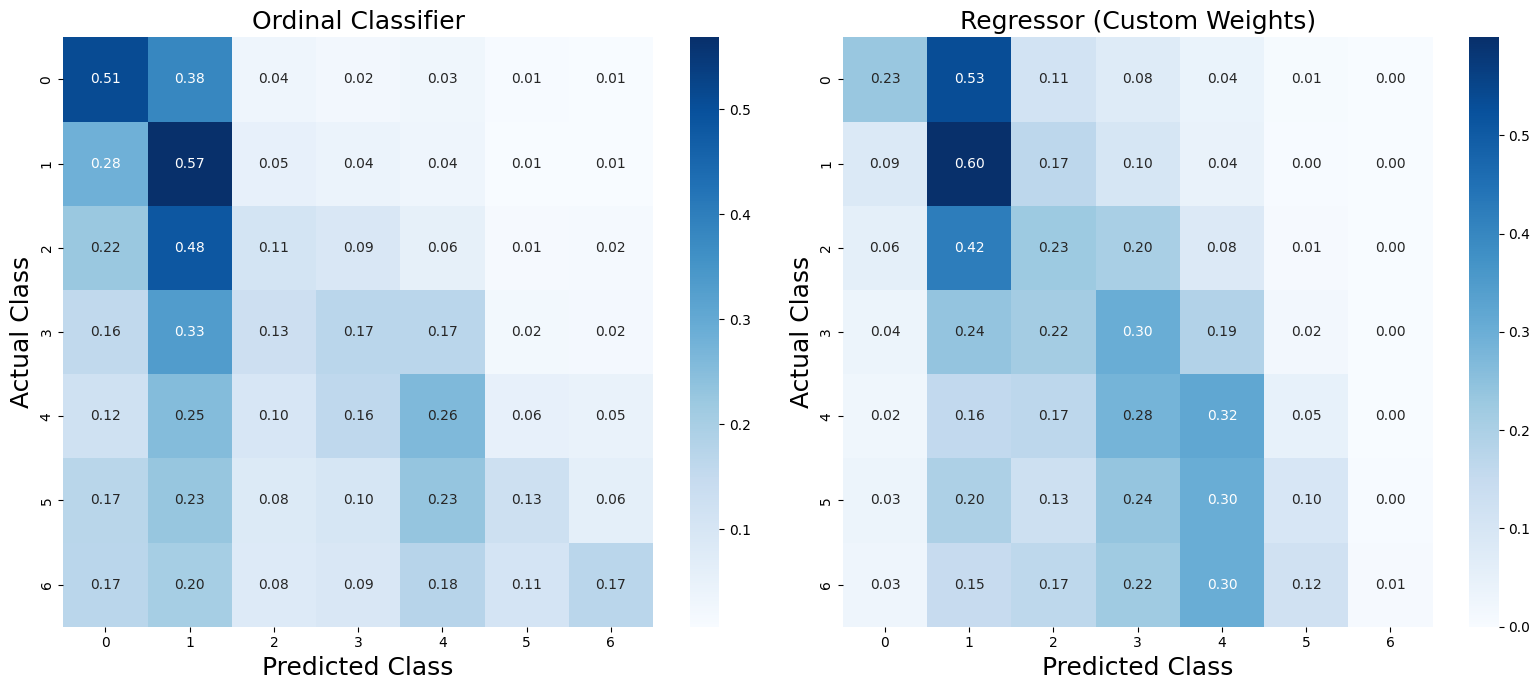

In [36]:
conf_matrix_ordinal = confusion_matrix(y_val, y_pred_ordinal)
conf_matrix_custom_weights = confusion_matrix(y_val, y_pred_regressor_custom_weights)

conf_matrix_ordinal_normalized = conf_matrix_ordinal.astype('float') / conf_matrix_ordinal.sum(axis=1)[:, np.newaxis]
conf_matrix_regressor_custom_weights_normalized = conf_matrix_custom_weights.astype('float') / conf_matrix_custom_weights.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16,7))

sns.heatmap(conf_matrix_ordinal_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val), ax=axes[0])
axes[0].set_title("Ordinal Classifier", fontsize=18)
axes[0].set_xlabel("Predicted Class", fontsize=18)
axes[0].set_ylabel("Actual Class", fontsize=18)

sns.heatmap(conf_matrix_regressor_custom_weights_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val), ax=axes[1])
axes[1].set_title("Regressor (Custom Weights)", fontsize=18)
axes[1].set_xlabel("Predicted Class", fontsize=18)
axes[1].set_ylabel("Actual Class", fontsize=18)

plt.tight_layout()
plt.show()

# Анализ важности признаков по группам

In [37]:
importances_list = []
for clf in ordinal_clf.clfs:
    # "FeatureImportance" даёт встроенные в CatBoost значения важности
    fi = clf.get_feature_importance(type='FeatureImportance')
    importances_list.append(fi)

# Превращаем список [fi1, fi2, ..., fiK] в матрицу и усредняем
importances_array = np.array(importances_list)  # shape = (кол-во бинарных моделей, кол-во фичей)
mean_importances = importances_array.mean(axis=0)

# Создаём DataFrame
feature_importance_df = pd.DataFrame({
    'feature': X_clf.columns,
    'importance': mean_importances
})

feature_importance_df['group'] = feature_importance_df['feature'].map(group_dict).fillna('unknown_group')

grouped_importance = (
    feature_importance_df
    .groupby('group')['importance']
    .sum()
    .reset_index()
    .sort_values(by='importance', ascending=False)
)

grouped_importance.columns = ['group', 'sum_importance']

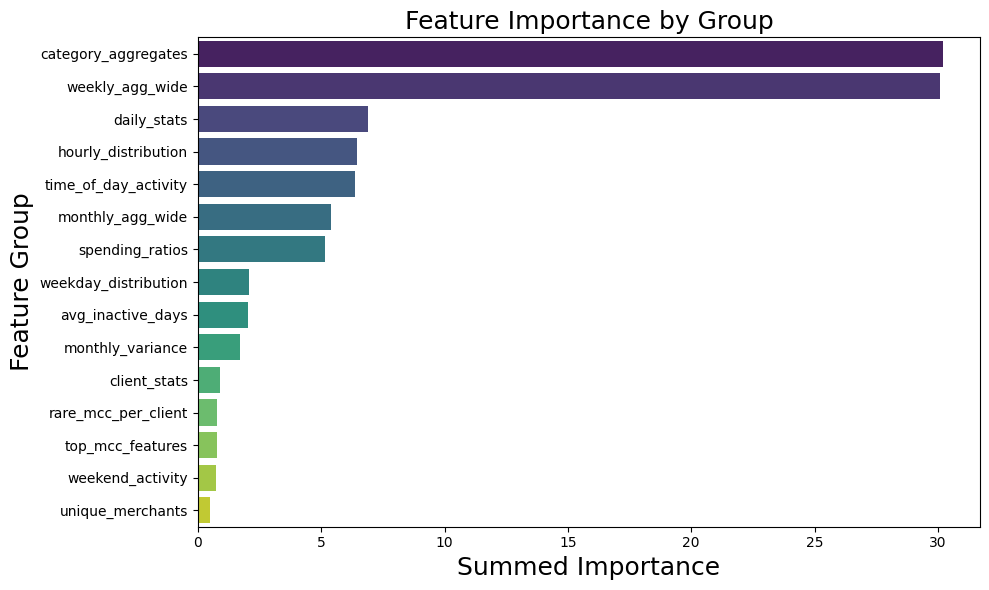

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=grouped_importance,
    x='sum_importance',
    y='group',
    palette='viridis'
)
plt.title('Feature Importance by Group', fontsize=18)
plt.xlabel('Summed Importance', fontsize=18)
plt.ylabel('Feature Group', fontsize=18)


plt.tight_layout()
plt.show()

# Предсказания на тестовой выборке

In [39]:
y_proba_test = ordinal_clf.predict_proba(X_test)
y_test_pred = regressor_custom_weights.predict(y_proba_test).round().astype(int)

submission = pd.DataFrame({
    'client_num': test_features['client_num'].values,
    'target': y_test_pred.flatten()
})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
